In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data_path = "data/chosen.jsonl"
tools_dir = "tools"

test_split = 0.2
seed = 42

In [3]:
os.makedirs(tools_dir, exist_ok=True)

# Wczytywanie danych

Analiza danych została przeprowadzona w poprzednim etapie. Teraz wczytujemy przetworzone dane z końca poprzedniego etapu. Został wybrany podzbiór atrybutów, które według nas i przeprowadzonej analizy mają największy potencjał w byciu informatywnymi.

In [4]:
df = pd.read_json(data_path, lines=True)

In [5]:
df

,offered_discount,product_price,offered_price,month_sin,month_cos,day_sin,day_cos,mean_previous_category_price,ratio,previous_all_discount_less_equal,previous_all_discount_greater,previous_category_discount_less_equal,previous_category_discount_greater,product_category,user_city,bought
0,5,58.97,56.0215,0.000000,1.000000e+00,-0.724793,0.688967,58.9700,0.950000,33,18,1,0,Telefony stacjonarne,Warszawa,True
1,0,1816.97,1816.9700,-0.866025,-5.000000e-01,-0.207912,0.978148,1544.4245,1.176471,19,14,0,1,Tablety,Warszawa,False
2,0,2317.02,2317.0200,-0.866025,-5.000000e-01,-0.207912,0.978148,1544.4245,1.500248,19,14,0,1,Tablety,Warszawa,True
3,20,299.00,239.2000,-1.000000,-1.836970e-16,0.000000,1.000000,86.2800,2.772369,34,0,1,0,Zestawy głośnomówiące,Warszawa,True
4,20,129.00,103.2000,-1.000000,-1.836970e-16,0.000000,1.000000,86.2800,1.196106,34,0,1,0,Zestawy głośnomówiące,Warszawa,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28931,10,86.28,77.6520,0.866025,5.000000e-01,0.485302,-0.874347,0.0000,1.000000,9,1,0,0,Zestawy głośnomówiące,Radom,False
28932,10,327.47,294.7230,0.866025,5.000000e-01,0.485302,-0.874347,0.0000,1.000000,9,1,0,0,Zestawy głośnomówiące,Radom,True
28933,10,245.00,220.5000,0.866025,5.000000e-01,0.485302,-0.874347,0.0000,1.000000,9,1,0,0,Zestawy głośnomówiące,Radom,False
28934,0,109.00,109.0000,0.866025,5.000000e-01,0.394356,0.918958,0.0000,1.000000,0,3,0,0,Odtwarzacze DVD,Radom,False


In [6]:
X = df.drop("bought", axis=1)
y = df["bought"].astype('int')

- X - wejścia
- y - zmienna celu

# Przygotowanie danych

#### Sanity check

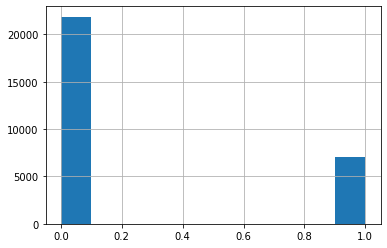

In [7]:
_ = y.hist()

In [8]:
np.count_nonzero(y == 1) / np.count_nonzero(y == 0)

0.32272810385810935

Klasy są niezbalansowane (w proporcji około 1:3)

In [9]:
X.isnull().sum().sum()

0

Nie ma już żadnych braków

#### Podział na zbiór uczący i testowy

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=seed)

#### Kodowanie

In [11]:
numerical_columns = X_train.select_dtypes("number").columns
categorical_columns = X_train.select_dtypes(exclude="number").columns

In [12]:
encoder = OneHotEncoder(handle_unknown='ignore').fit(X_train[categorical_columns])

In [13]:
encoded_categorical_train = pd.DataFrame(encoder.transform(X_train[categorical_columns]).toarray(), columns=encoder.get_feature_names(input_features=categorical_columns))
encoded_categorical_train.index = X_train.index
encoded_categorical_test = pd.DataFrame(encoder.transform(X_test[categorical_columns]).toarray(), columns=encoder.get_feature_names(input_features=categorical_columns))
encoded_categorical_test.index = X_test.index

In [14]:
X_train = pd.concat([X_train[numerical_columns], encoded_categorical_train], axis=1)
X_test = pd.concat([X_test[numerical_columns], encoded_categorical_test], axis=1)

In [15]:
X_train

,offered_discount,product_price,offered_price,month_sin,month_cos,day_sin,day_cos,mean_previous_category_price,ratio,previous_all_discount_less_equal,...,product_category_Zestawy głośnomówiące,product_category_Zestawy słuchawkowe,user_city_Gdynia,user_city_Konin,user_city_Kutno,user_city_Mielec,user_city_Police,user_city_Radom,user_city_Szczecin,user_city_Warszawa
5345,0,3029.00,3029.000,0.866025,0.5,9.987165e-01,-0.050649,643.100000,4.709998,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17661,15,245.00,208.250,0.866025,0.5,-6.513725e-01,-0.758758,129.000000,1.614341,26,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17237,0,42.90,42.900,0.866025,-0.5,-1.011683e-01,-0.994869,0.000000,1.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15006,20,129.00,103.200,0.866025,0.5,-9.377521e-01,0.347305,142.393500,0.724752,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5290,0,119.00,119.000,0.866025,0.5,-4.853020e-01,-0.874347,95.294100,1.248766,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,20,1117.01,893.608,0.866025,0.5,9.987165e-01,-0.050649,362.383333,2.465919,47,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5390,5,189.00,179.550,0.866025,0.5,9.377521e-01,0.347305,59.990000,2.992999,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
860,0,1117.01,1117.010,-0.866025,-0.5,1.224647e-16,-1.000000,0.000000,1.000000,11,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15795,0,3029.00,3029.000,0.866025,0.5,5.712682e-01,0.820763,620.718571,4.879828,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Po zakodowaniu mamy 36 kolumn

In [16]:
with open(tools_dir + '/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

Zapiszemy enkoder, żeby użyć go później na serwerze

#### Normalizacja

In [17]:
scaler = StandardScaler().fit(X_train)

In [18]:
X_train.loc[:, :] = scaler.transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

In [19]:
X_train

,offered_discount,product_price,offered_price,month_sin,month_cos,day_sin,day_cos,mean_previous_category_price,ratio,previous_all_discount_less_equal,...,product_category_Zestawy głośnomówiące,product_category_Zestawy słuchawkowe,user_city_Gdynia,user_city_Konin,user_city_Kutno,user_city_Mielec,user_city_Police,user_city_Radom,user_city_Szczecin,user_city_Warszawa
5345,-0.710422,1.510971,1.613797,0.769772,0.057748,1.388908,-0.045510,0.113717,1.128801,-0.267695,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535
17661,1.414877,-0.371406,-0.387367,0.769772,0.057748,-0.924952,-1.056041,-0.325607,0.113205,0.670824,...,3.939858,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,2.359803,-0.393741,-0.380535
17237,-0.710422,-0.508054,-0.504673,0.769772,-1.824510,-0.153421,-1.392991,-0.435844,-0.088342,-1.206214,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,2.359803,-0.393741,-0.380535
15006,2.123310,-0.449838,-0.461894,0.769772,0.057748,-1.326532,0.522404,-0.314161,-0.178643,1.681537,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,2.359803,-0.393741,-0.380535
5290,-0.710422,-0.456600,-0.450685,0.769772,0.057748,-0.692077,-1.220995,-0.354410,-0.006730,0.670824,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,2.123310,0.218196,0.098856,0.769772,0.057748,1.388908,-0.045510,-0.126169,0.392583,2.186893,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,2.389470,-0.440170,-0.423764,-0.393741,-0.380535
5390,-0.001989,-0.409270,-0.407728,0.769772,0.057748,1.303420,0.522404,-0.384579,0.565503,-0.195501,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535
860,-0.710422,0.218196,0.257347,-2.392665,-1.824510,-0.011556,-1.400313,-0.435844,-0.088342,-0.412083,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,2.271849,-0.423764,-0.393741,-0.380535
15795,-0.710422,1.510971,1.613797,0.769772,0.057748,0.789513,1.198068,0.094591,1.184518,0.670824,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535


In [20]:
with open(tools_dir + '/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Zapiszemy... skaler(?), żeby użyć go później na serwerze

In [21]:
X_train

,offered_discount,product_price,offered_price,month_sin,month_cos,day_sin,day_cos,mean_previous_category_price,ratio,previous_all_discount_less_equal,...,product_category_Zestawy głośnomówiące,product_category_Zestawy słuchawkowe,user_city_Gdynia,user_city_Konin,user_city_Kutno,user_city_Mielec,user_city_Police,user_city_Radom,user_city_Szczecin,user_city_Warszawa
5345,-0.710422,1.510971,1.613797,0.769772,0.057748,1.388908,-0.045510,0.113717,1.128801,-0.267695,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535
17661,1.414877,-0.371406,-0.387367,0.769772,0.057748,-0.924952,-1.056041,-0.325607,0.113205,0.670824,...,3.939858,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,2.359803,-0.393741,-0.380535
17237,-0.710422,-0.508054,-0.504673,0.769772,-1.824510,-0.153421,-1.392991,-0.435844,-0.088342,-1.206214,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,2.359803,-0.393741,-0.380535
15006,2.123310,-0.449838,-0.461894,0.769772,0.057748,-1.326532,0.522404,-0.314161,-0.178643,1.681537,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,2.359803,-0.393741,-0.380535
5290,-0.710422,-0.456600,-0.450685,0.769772,0.057748,-0.692077,-1.220995,-0.354410,-0.006730,0.670824,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,2.123310,0.218196,0.098856,0.769772,0.057748,1.388908,-0.045510,-0.126169,0.392583,2.186893,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,2.389470,-0.440170,-0.423764,-0.393741,-0.380535
5390,-0.001989,-0.409270,-0.407728,0.769772,0.057748,1.303420,0.522404,-0.384579,0.565503,-0.195501,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535
860,-0.710422,0.218196,0.257347,-2.392665,-1.824510,-0.011556,-1.400313,-0.435844,-0.088342,-0.412083,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,2.271849,-0.423764,-0.393741,-0.380535
15795,-0.710422,1.510971,1.613797,0.769772,0.057748,0.789513,1.198068,0.094591,1.184518,0.670824,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535


In [22]:
y_train

5345     0
17661    0
17237    0
15006    0
5290     1
        ..
21575    0
5390     0
860      0
15795    0
23654    1
Name: bought, Length: 23148, dtype: int64

In [23]:
X_test

,offered_discount,product_price,offered_price,month_sin,month_cos,day_sin,day_cos,mean_previous_category_price,ratio,previous_all_discount_less_equal,...,product_category_Zestawy głośnomówiące,product_category_Zestawy słuchawkowe,user_city_Gdynia,user_city_Konin,user_city_Kutno,user_city_Mielec,user_city_Police,user_city_Radom,user_city_Szczecin,user_city_Warszawa
18464,0.706444,0.218196,0.178102,0.769772,0.057748,1.345944,-0.330932,0.081161,0.128729,-0.267695,...,-0.253816,-0.245022,-0.38061,3.495694,-0.281713,-0.418503,-0.440170,-0.423764,-0.393741,-0.380535
24628,2.123310,-0.483713,-0.490329,-1.724364,-2.513464,0.789513,1.198068,-0.404700,0.151781,-0.123308,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535
2641,-0.710422,-0.396876,-0.388020,-0.811447,-2.765638,0.270718,1.424641,-0.435844,-0.088342,-0.556470,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,2.359803,-0.393741,-0.380535
17852,2.123310,-0.267280,-0.308654,0.769772,0.057748,1.178467,0.781646,0.174304,-0.269747,0.093274,...,-0.253816,-0.245022,-0.38061,-0.286066,3.549714,-0.418503,-0.440170,-0.423764,-0.393741,-0.380535
22373,-0.710422,-0.409270,-0.401024,-0.811447,0.998876,0.541435,1.338200,-0.435844,-0.088342,-1.206214,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,2.389470,-0.440170,-0.423764,-0.393741,-0.380535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28048,1.414877,-0.514755,-0.515215,0.101470,0.746702,1.057197,0.950645,-0.384301,-0.263889,-0.556470,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,-0.393741,2.627877
8292,0.706444,-0.524958,-0.523679,-0.811447,0.998876,1.178467,0.781646,-0.435844,-0.088342,-0.123308,...,-0.253816,-0.245022,-0.38061,3.495694,-0.281713,-0.418503,-0.440170,-0.423764,-0.393741,-0.380535
24563,-0.710422,-0.508054,-0.504673,1.014387,-0.883381,0.812674,-1.127764,-0.435844,-0.088342,-1.061827,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,-0.440170,-0.423764,2.539739,-0.380535
22019,2.123310,-0.463361,-0.473245,0.769772,0.057748,1.097320,-0.846756,-0.287409,-0.251717,1.681537,...,-0.253816,-0.245022,-0.38061,-0.286066,-0.281713,-0.418503,2.271849,-0.423764,-0.393741,-0.380535


In [24]:
y_test

18464    0
24628    0
2641     0
17852    0
22373    1
        ..
28048    0
8292     0
24563    1
22019    0
563      0
Name: bought, Length: 5788, dtype: int64

# Uczenie

In [25]:
from sklearn.dummy import DummyClassifier
clfD = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)

In [26]:
from sklearn.linear_model import LogisticRegression
clfA = LogisticRegression().fit(X_train, y_train)

In [27]:
from sklearn.ensemble import RandomForestClassifier
clfB = RandomForestClassifier(max_depth=10).fit(X_train, y_train)

Tworzymy bazowe klasyfikatory przed strojeniem hiperparametrów

Następnie robimy strojenie

In [28]:
from sklearn.metrics import make_scorer
scorer = make_scorer(balanced_accuracy_score)

In [29]:
params = {
    "penalty": ["none", "l2"],
    "tol": [1e-4, 1e-5, 1e-3],
    "C": [1, 2, 3],
    "fit_intercept": [True, False],
    "class_weight": ["balanced", None],
    "max_iter": np.arange(50, 150)
}
model = LogisticRegression()
grid = RandomizedSearchCV(model, params, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))
grid.best_params_


0.7966482377332412


{'tol': 1e-05,
 'penalty': 'l2',
 'max_iter': 108,
 'fit_intercept': True,
 'class_weight': None,
 'C': 1}

Strojenie regresji daje prawie niezmienione parametry domyślne

In [30]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3,5,8,12,15,30],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}
model = RandomForestClassifier(class_weight="balanced", n_estimators=500)
grid = GridSearchCV(model, params, scoring=scorer, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))
grid.best_params_


Wyjście GridSearchCV:
(Po długim czasie)

0.6839481308144144

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2'}
 
 Komórka GridSearch zamieniona na Markdown aby nie można jej było przez przypadek uruchomić

Strojenie Random Forest

In [31]:
clfA_tuned = LogisticRegression(tol=1e-5, penalty='l2', max_iter=78, fit_intercept=True,
                          class_weight=None, C=2).fit(X_train, y_train)

In [32]:
clfB_tuned = RandomForestClassifier(max_features='log2', max_depth=8, n_estimators=500, criterion='entropy', 
                                    bootstrap=True, class_weight="balanced", n_jobs=-1).fit(X_train, y_train)

Tworzymy modele z nastrojonymi hiperparametrami

# Porównanie

Żeby zademonstrować poprawność kryterium Balanced Accuracy Score, przetestujemy DummyClassifier który zawsze przewiduje najczęstszą klasę

In [41]:
print("Zbiór testowy\nScore: ")
print(clfD.score(X_test, y_test))

print("Balanced Accuracy Score: ")
print(balanced_accuracy_score(y_test, clfD.predict(X_test)))

Zbiór testowy
Score: 
0.7541465100207325
Balanced Accuracy Score: 
0.5


Jak widać, przewiduje poprawnie w 3/4 przypadków, ale Balanced Accuracy Score wynosi dokładnie 0.5, tak jak powinien

Najpierw porównujemy wyniki modeli nienastrojonych:

Zbiór treningowy
Balanced Accuracy Score: 
0.6574509889913643
Zbiór testowy
Score: 
0.7966482377332412
Balanced Accuracy Score: 
0.6513265538578693


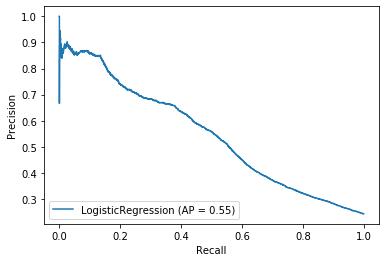

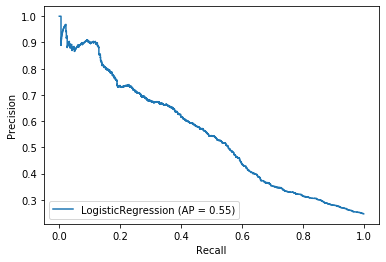

In [42]:
print("Zbiór treningowy\nBalanced Accuracy Score: ")
print(balanced_accuracy_score(y_train, clfA.predict(X_train)))

disp = plot_precision_recall_curve(clfA, X_train, y_train)

print("Zbiór testowy\nScore: ")
print(clfA.score(X_test, y_test))

print("Balanced Accuracy Score: ")
print(balanced_accuracy_score(y_test, clfA.predict(X_test)))

disp = plot_precision_recall_curve(clfA, X_test, y_test)

Zbiór treningowy
Balanced Accuracy Score: 
0.637369215105086
Zbiór testowy
Score: 
0.7847270214236352
Balanced Accuracy Score: 
0.5958213895590282


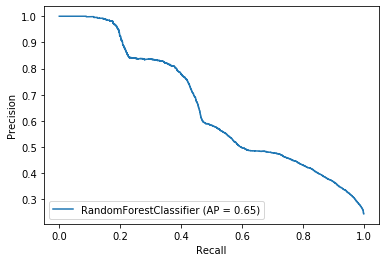

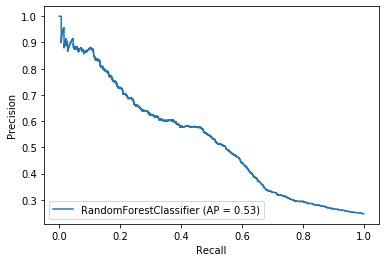

In [43]:
print("Zbiór treningowy\nBalanced Accuracy Score: ")
print(balanced_accuracy_score(y_train, clfB.predict(X_train)))

disp = plot_precision_recall_curve(clfB, X_train, y_train)

print("Zbiór testowy\nScore: ")
print(clfB.score(X_test, y_test))

print("Balanced Accuracy Score: ")
print(balanced_accuracy_score(y_test, clfB.predict(X_test)))

disp = plot_precision_recall_curve(clfB, X_test, y_test)

Następnie wyniki modeli nastrojonych:

Zbiór treningowy
Balanced Accuracy Score: 
0.6574509889913643
Zbiór testowy
Score: 
0.7966482377332412
Balanced Accuracy Score: 
0.6513265538578693


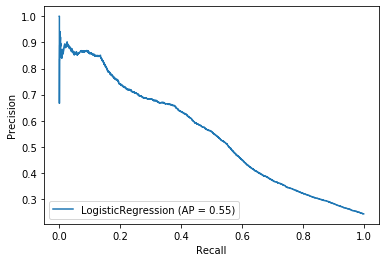

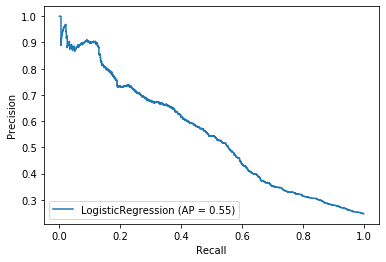

In [44]:
print("Zbiór treningowy\nBalanced Accuracy Score: ")
print(balanced_accuracy_score(y_train, clfA_tuned.predict(X_train)))

disp = plot_precision_recall_curve(clfA_tuned, X_train, y_train)

print("Zbiór testowy\nScore: ")
print(clfA_tuned.score(X_test, y_test))

print("Balanced Accuracy Score: ")
print(balanced_accuracy_score(y_test, clfA_tuned.predict(X_test)))

disp = plot_precision_recall_curve(clfA_tuned, X_test, y_test)

Zbiór treningowy
Balanced Accuracy Score: 
0.6930671784228444
Zbiór testowy
Score: 
0.7641672425708362
Balanced Accuracy Score: 
0.6852081537239219


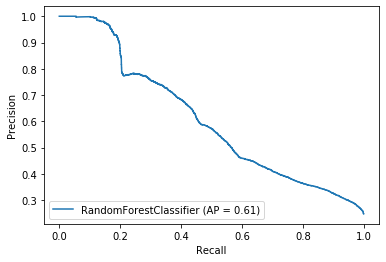

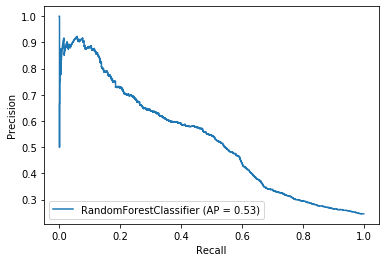

In [45]:
print("Zbiór treningowy\nBalanced Accuracy Score: ")
print(balanced_accuracy_score(y_train, clfB_tuned.predict(X_train)))

disp = plot_precision_recall_curve(clfB_tuned, X_train, y_train)

print("Zbiór testowy\nScore: ")
print(clfB_tuned.score(X_test, y_test))

print("Balanced Accuracy Score: ")
print(balanced_accuracy_score(y_test, clfB_tuned.predict(X_test)))

disp = plot_precision_recall_curve(clfB_tuned, X_test, y_test)

Jak można zauważyć, strojenie Random Forest znacznie poprawia wyniki

Na koniec zapisujemy modele do plików zewnętrznych

In [37]:
with open(tools_dir + '/A.pkl', 'wb') as f:
    pickle.dump(clfA_tuned, f)
    
with open(tools_dir + '/B.pkl', 'wb') as f:
    pickle.dump(clfB_tuned, f)